In [103]:
import cv2
import numpy as np
def show_img(image):
    # OpenCV 读取的图像是 BGR 格式，而 Matplotlib 显示的是 RGB 格式
    # 因此需要将图像从 BGR 转换为 RGB
    if image is None: print("Error: Unable to load image.")
    else:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # 使用 Matplotlib 显示图像
        plt.figure(figsize=(6, 6))
        plt.imshow(image_rgb)
        plt.axis('off')  # 关闭坐标轴
        plt.show()

Image shape: (412, 512)
Mask shape: (412, 512)


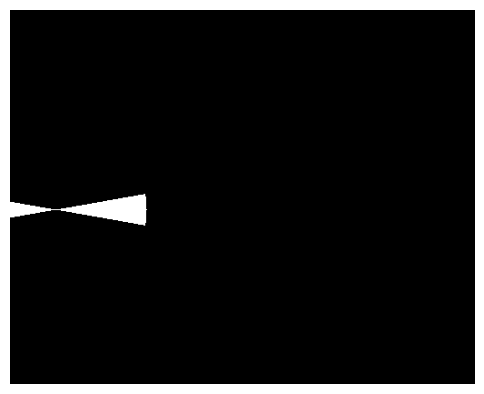

In [108]:


def rotate(x, y, angle):
    """旋转函数，将点 (x, y) 绕原点旋转指定角度 (angle)，返回新坐标"""
    cos_a = np.cos(angle)
    sin_a = np.sin(angle)
    x_new = cos_a * x - sin_a * y
    y_new = sin_a * x + cos_a * y
    return x_new, y_new

def cross(vx, vy, ux, uy):
    """计算两个向量的叉积"""
    return vx * uy - vy * ux


def get_scan_zone_mask(img, x0, y0, xp, yp, alpha, scan_zone_r):
    # 生成与 img 相同大小的掩码
    mask = np.zeros_like(img, dtype=bool)

    # 生成网格，这里 X 对应列，Y 对应行
    Y, X = np.meshgrid(np.arange(img.shape[0]), np.arange(img.shape[1]), indexing='ij')

    X_shifted = X - x0
    Y_shifted = Y - y0

    # 计算圆形掩码
    round_mask = X_shifted ** 2 + Y_shifted ** 2 <= scan_zone_r ** 2

    # 限制点到圆形范围后再计算
    X_shifted = X_shifted[round_mask]
    Y_shifted = Y_shifted[round_mask]

    # 计算旋转后的点
    xp1, yp1 = rotate(xp - x0, yp - y0, alpha)
    xp2, yp2 = rotate(xp - x0, yp - y0, -alpha)

    # 计算向量 (x0, y0) -> (xp1, yp1) 和 (x0, y0) -> (xp2, yp2)
    v1_x, v1_y = xp1, yp1
    v2_x, v2_y = xp2, yp2

    # 计算交叉乘积
    cross_prod1 = cross(v1_x, v1_y, X_shifted, Y_shifted)
    cross_prod2 = cross(v2_x, v2_y, X_shifted, Y_shifted)
    reversed_cross_prod1 = cross(-v1_x, -v1_y, X_shifted, Y_shifted)
    reversed_cross_prod2 = cross(-v2_x, -v2_y, X_shifted, Y_shifted)

    # 创建角度区域掩码
    angle_mask = (reversed_cross_prod1 >= 0) & (reversed_cross_prod2 <= 0) | (cross_prod1 >= 0) & (cross_prod2 <= 0)

    # 合并掩码，更新原始的 mask
    mask[round_mask] = angle_mask

    return mask

# 测试代码
img = np.zeros((412, 512))  # 图像大小
x0, y0 = 50, 220  # 原点坐标
xp, yp = 100, 220  # 扫描区域的目标点
alpha = np.radians(10)  # 旋转角度
scan_zone_r = 100  # 扫描区域半径

mask = get_scan_zone_mask(img, x0, y0, xp, yp, alpha, scan_zone_r)

print("Image shape:", img.shape)
print("Mask shape:", mask.shape)

img[mask] = 255


#
img = img.astype(np.uint8)
show_img(img)
#
# save_cv_image_with_plt(img , '../test.jpg')